In [8]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import idx2numpy


In [9]:
X_train = idx2numpy.convert_from_file("data/train-images-idx3-ubyte")
Y_train = idx2numpy.convert_from_file("data/train-labels-idx1-ubyte")
X_test = idx2numpy.convert_from_file("data/t10k-images-idx3-ubyte")
Y_test = idx2numpy.convert_from_file("data/t10k-labels-idx1-ubyte")

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
# Normalize the data
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(X_train)
X_test_data_minmax = MinMaxScaler.fit_transform(X_test)

In [10]:
def subsample_training(X, Y, M):
    from numpy.random import default_rng
    assert X.shape[0] == Y.shape[0]
    assert M < X.shape[0]
    rng = default_rng()
    idxs = rng.choice(X.shape[0], size=M, replace=False)
    return X.take(idxs, axis=0), Y.take(idxs, axis=0)

In [14]:
def remove_outliers(X, Y):
    knn_clf=KNeighborsClassifier(n_neighbors=5, metric="euclidean")
    knn_clf.fit(X, Y)
    ypred=knn_clf.predict(X)
    outliers = ypred != Y
    # remove outliers
    X, Y = X[~outliers], Y[~outliers]
    return X, Y

    pass
def keep_useful(X, Y):
    useful_X, useful_Y = [], []
    labels_vis = set()
    for x, y in zip(X, Y):
        if y not in labels_vis:
            useful_X.append(x)
            useful_Y.append(y)
            labels_vis.add(y)
        else:
            # Check if the value is misclassified
            #import ipdb;ipdb.set_trace()
            knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
            knn_clf.fit(useful_X, useful_Y)
            ypred=knn_clf.predict([x])
            if ypred[0] != y:
                useful_X.append(x)
                useful_Y.append(y)
    return useful_X, useful_Y            


def prototype_selection(X, Y):
    orignal_sz = len(Y)
    X, Y = remove_outliers(X, Y)
    X, Y = keep_useful(X, Y)
    print(f"Factor by which the dataset is reduces is {orignal_sz/len(Y)} ")
    return X, Y

In [15]:
def predict_values_and_calculate_accuracy_uniform_random(M):
    # 1 NN, distance = Euclidian
    knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    X, Y = subsample_training(X_data_minmax, Y_train, M)
    knn_clf.fit(X, Y)
    ypred=knn_clf.predict(X_test_data_minmax)
    result = confusion_matrix(Y_test, ypred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(Y_test, ypred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(Y_test,ypred)
    # print(type(result1))
    print("Accuracy:",result2)
    return result2

def predict_values_and_calculate_accuracy_prototype_subset(M):
    # 1 NN, distance = Euclidian
    knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    X, Y = subsample_training(X_data_minmax, Y_train, M)
    X, Y = prototype_selection(X, Y)

    knn_clf.fit(X, Y)
    ypred=knn_clf.predict(X_test_data_minmax)
    # result = confusion_matrix(Y_test, ypred)
    # print("Confusion Matrix:")
    # print(result)
    #result1 = classification_report(Y_test, ypred)
    #print("Classification Report:",)
    #print (result1)
    result2 = accuracy_score(Y_test,ypred)
    #print("Accuracy:",result2)
    return result2




In [16]:
def test_multiple_iterations(num_iterations, M):
    accuracies_uniform = []
    accuracies_prototype_selection = []
    for i in range(num_iterations):
        accuracies_uniform.append(predict_values_and_calculate_accuracy_uniform_random(M))
        accuracies_prototype_selection.append(predict_values_and_calculate_accuracy_prototype_subset(M))
    print(accuracies_uniform)    
    import matplotlib.pyplot as plt
    import numpy as np

    #plt.ylim(-0.2, 2)
    labels = [f"{M}_{i}" for i in range(num_iterations)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies_uniform, width, label='Men')
    rects2 = ax.bar(x + width/2, accuracies_prototype_selection, width, label='Women')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylim(-0.2, 2)
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    #ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()    

Confusion Matrix:
[[ 944    1    0    2    0   12   18    1    1    1]
 [   0 1128    2    1    0    0    2    0    0    2]
 [  21   36  847   26   16    6    9   51   15    5]
 [   6    8    8  900    0   35    2   16   21   14]
 [   2   27    0    0  823    1   12   13    2  102]
 [  11   15    0   57    3  731   23    6   15   31]
 [  13   12    1    1    6   11  908    0    3    3]
 [   0   44    1    3   11    1    0  922    2   44]
 [  13   19   10   70   13   33    9   15  749   43]
 [   8   16    1    7   43    6    1   40    7  880]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       980
           1       0.86      0.99      0.92      1135
           2       0.97      0.82      0.89      1032
           3       0.84      0.89      0.87      1010
           4       0.90      0.84      0.87       982
           5       0.87      0.82      0.85       892
           6       0.92      0.95      0.94      

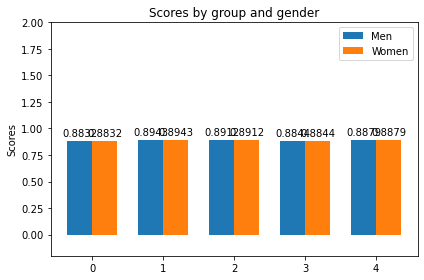

In [17]:
test_multiple_iterations(5, 1000)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy: 0.9691


In [24]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]],
              [[3, 4, 5, 6], [5, 6, 7, 8]],
              [[4, 4, 5, 6], [5, 6, 7, 9]]])
#x[np.array([0, 1, 1], dtype="bool")]
x.take([1,2], axis=0)

array([[[3, 4, 5, 6],
        [5, 6, 7, 8]],

       [[4, 4, 5, 6],
        [5, 6, 7, 9]]])